In [1]:
# Import necessary libraries
import scipy.io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial.distance import pdist, squareform
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from umap import UMAP
from sklearn.decomposition import PCA
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.manifold import TSNE
from scipy.stats import kendalltau
import numpy as np
warnings.filterwarnings('ignore')

# 0. Visualization of the Original Data

In [2]:
# Define some helper functions

# Plot images with corresponding IDs
def plot_face_with_id(all_images, all_ids, indices=None):
    """
    Plot images with their corresponding IDs.

    Args:
    - all_images (numpy array): Array of images.
    - all_ids (numpy array): Array of IDs corresponding to each image.
    - indices (list, optional): List of indices to plot. If None, plot all images.

    Returns:
    - None
    """
    if indices is not None:
        all_images = all_images[:, :, indices]
        all_ids = all_ids[:, indices]

    # Set the number of rows and columns for the plot
    rows = 3
    images_num = all_images.shape[2]
    cols = int(np.ceil(images_num / rows))

    fig, axes = plt.subplots(rows, int(np.ceil(images_num / rows)), figsize=(15, 5))
    for i in range(images_num):
        row = i // cols  # Calculate the current row for the image
        col = i % cols   # Calculate the current column for the image
        ax = axes[row, col]  # Access the subplot using row and column
        image = all_images[:, :, i]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"ID: {all_ids[:, i]}", fontsize=10)

    # Display the images
    plt.show()


# Plot 2D positions sorted by IDs
def plot_2d_sorted_position(X_position, Y_position, all_images, Ground_truth_ids, title):
    """
    Plot 2D positions sorted by IDs.

    Args:
    - X_position (numpy array): X-axis positions.
    - Y_position (numpy array): Y-axis positions.
    - all_images (numpy array): Array of images.
    - Ground_truth_ids (numpy array): Array of ground truth IDs.
    - title (str): Title of the plot.

    Returns:
    - None
    """
    sns.set_style("white", {'axes.grid': False})

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    # Calculate the boundaries with some padding
    x_min, x_max = np.min(X_position), np.max(X_position)
    y_min, y_max = np.min(Y_position), np.max(Y_position)
    x_pad = (x_max - x_min) * 0.15  # 15% padding
    y_pad = (y_max - y_min) * 0.15  # 15% padding

    axs[0].scatter(X_position, Y_position, c=Ground_truth_ids, cmap="winter", s=50)

    axs[1].scatter(X_position, Y_position)
    num_points = len(X_position)
    for i in range(num_points):
        im = all_images[:, :, i]
        imagebox = OffsetImage(im, zoom=0.2, cmap='gray', alpha=1)
        ab = AnnotationBbox(imagebox, (X_position[i], Y_position[i]), frameon=False)
        axs[1].add_artist(ab)

    plt.suptitle(title)

    for sub_fig in range(2):
        axs[sub_fig].axis('on')  # Keep axis but remove labels
        axs[sub_fig].set_xlim(x_min - x_pad, x_max + x_pad)
        axs[sub_fig].set_ylim(y_min - y_pad, y_max + y_pad)

Images shape: (112, 92, 33)
IDs shape: (1, 33)


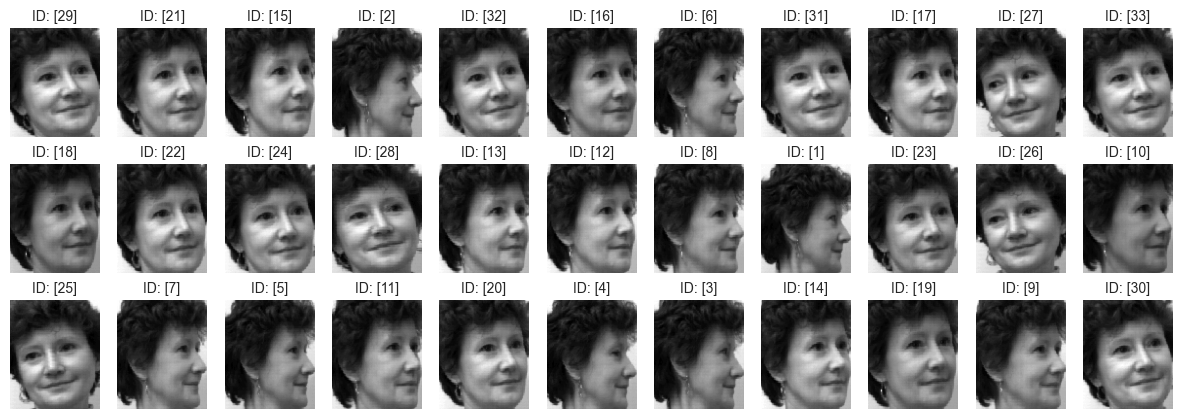

In [3]:
# Load the .mat file
data = scipy.io.loadmat("face.mat")

# Extract the image data and IDs
images = data['Y']
ids = data['id']
print("Images shape:", images.shape)
print("IDs shape:", ids.shape)

# Plot images with corresponding IDs
plot_face_with_id(images, ids)

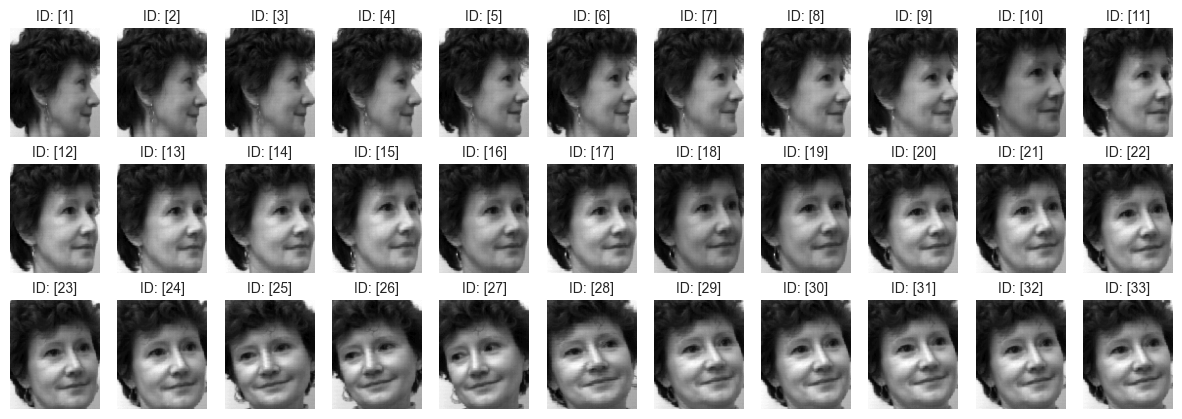

In [4]:
# Sort the images by IDs
sorted_indices = np.argsort(ids[0])

# Plot the images sorted by IDs
plot_face_with_id(images, ids, indices=sorted_indices)


In [5]:
# Reshape the data to (33, 10304)
X = np.transpose(images, (2, 0, 1)).reshape(33, 112*92)
print("Reshaped X shape:", X.shape)

Reshaped X shape: (33, 10304)


## 0.1 Grond truth

[26 21 15  2 29 16  6 28 17 33 30 18 22 24 25 13 12  8  1 23 32 10 31  7
  5 11 20  4  3 14 19  9 27]


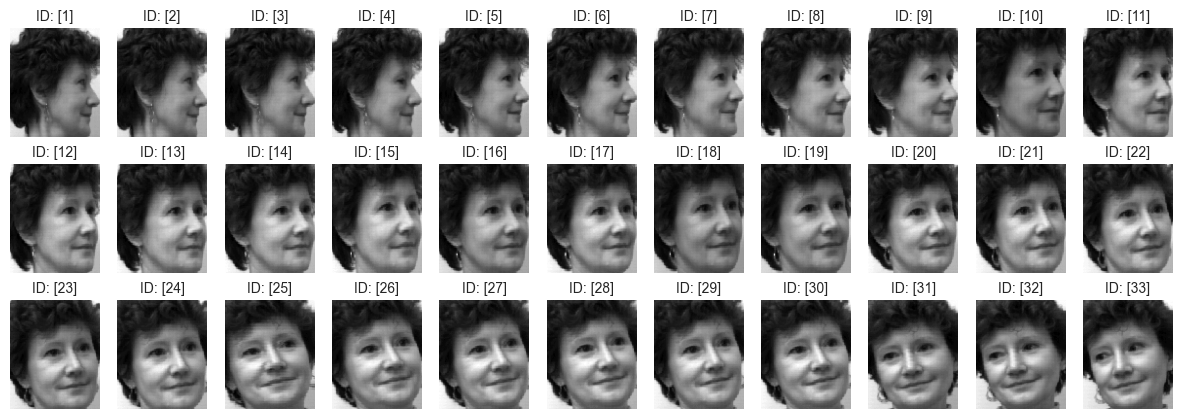

In [6]:
# Create a copy of the IDs
GT_ids = np.copy(ids)

# Define a dictionary to switch the IDs
switch_dict = {25: 31, 26: 32, 27: 33, 28: 25, 29: 26, 30: 27, 31: 28, 32: 29, 33: 30}

# Iterate over the IDs and switch them if needed
for temp_index, temp_id in enumerate(GT_ids[0]):
    if temp_id in switch_dict.keys():
        GT_ids[0][temp_index] = switch_dict[temp_id]

# Print the modified IDs
print(GT_ids[0])

# Sort the IDs and get the corresponding indices
GT_indices = np.argsort(GT_ids[0])

# Plot the sorted images
plot_face_with_id(images, GT_ids, indices=GT_indices)

# 1. Diffusion map embedding
Explore the Diffusion map, or the second smallest eigenvector of Markov Chains defined on the point cloud data, to order the faces, i.e., let $W_{ij}=\text{exp}(−\|x_i−x_j\|^2/t)$ with $D = \text{diag}(\sum_j W_{ij})$ and define $L = D^{-1}W - I$, clearly $\lambda_0 = 0$ and take the (second) smallest nonzero eigenvalue $\lambda_1$ with corresponding eigenvector $v_1$, sort the faces by values $v_1(i)$, $i= 1, \ldots, n$.


In [7]:
def diffusion_map_sorting(X, t=None):
    """
    Perform diffusion map sorting on the given data.

    Args:
    - X (numpy array): Data matrix of shape (n_samples, n_features).
    - t (float, optional): Time parameter for diffusion. If None, set to the median of the squared pairwise distances.

    Returns:
    - eigenvectors (numpy array): Matrix of eigenvectors.
    """
    # Compute pairwise squared Euclidean distances
    dist_sq = squareform(pdist(X, 'sqeuclidean'))

    # Set default value for time parameter if not provided
    if t is None:
        t = np.median(dist_sq)

    n_samples, n_features = X.shape
    W = np.zeros((n_samples, n_samples))

    # Compute the weight matrix W
    for i in range(n_samples):
        for j in range(n_samples):
            diff = X[i] - X[j]
            distance_squared = np.sum(diff ** 2)
            W[i, j] = np.exp(-distance_squared / t)

    # Compute the degree matrix D and its inverse
    D = np.diag(np.sum(W, axis=1))
    D_inv = np.linalg.inv(D)

    # Compute the Laplacian matrix L
    L = np.dot(D_inv, W) - np.eye(W.shape[0])

    # Compute the eigenvectors of L
    eigenvalues, eigenvectors = np.linalg.eig(L)
    # Print the top two eigenvalues with four decimal places
    print("Top two eigenvalues: {:.4f}, {:.4f}".format(eigenvalues[0], eigenvalues[1]))

    return eigenvectors

# Perform diffusion map sorting on the data X
diff = diffusion_map_sorting(X)

Top two eigenvalues: -0.0000, -1.0220


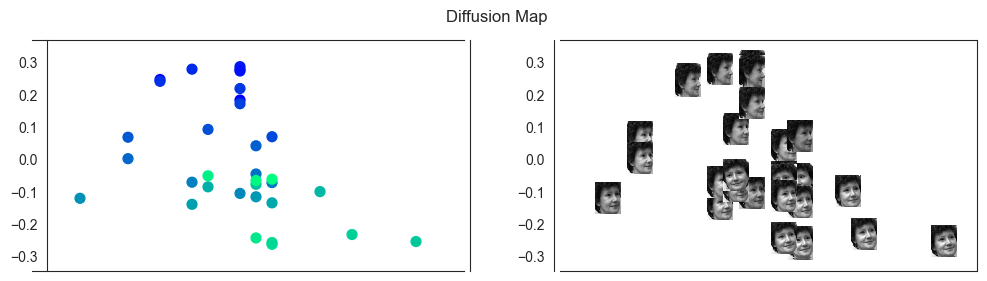

In [8]:
# Plot the 2D positions sorted by the first two diffusion map eigenvectors
plot_2d_sorted_position(diff[:, 0], diff[:, 1], images, GT_ids, "Diffusion Map")

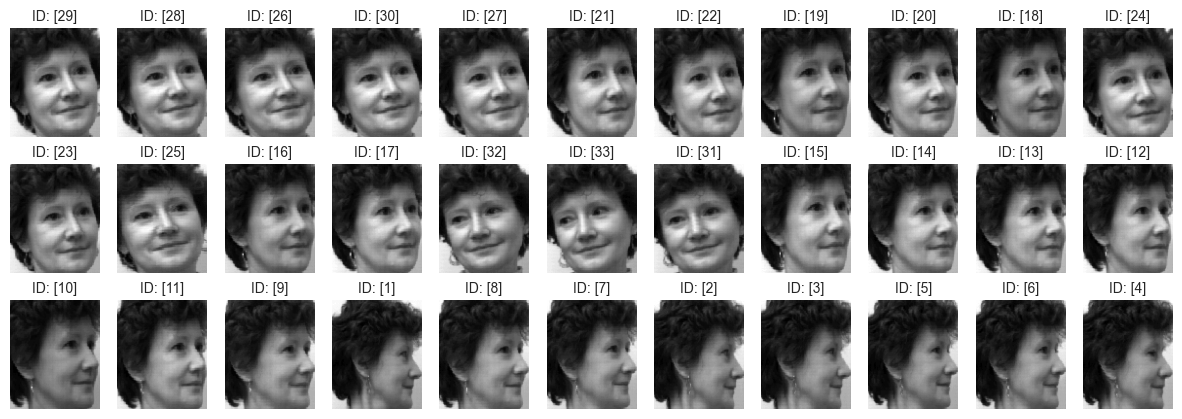

In [9]:
# Extract the second smallest eigenvector
diffusion_embedding = diff[:, 1]

# Sort the indices based on the second smallest eigenvector
sorted_indices = np.argsort(diffusion_embedding)

# Plot the images sorted by the second smallest eigenvector
plot_face_with_id(images, GT_ids, indices=sorted_indices)

# 2. MDS embedding
Explore the MDS-embedding of the 33 faces on top two eigenvectors: order the faces according to the top 1st eigenvector and visualize your results with figures.

In [10]:
# Perform Multidimensional Scaling (MDS) to reduce the dimensiona|lity to 2
mds = MDS(n_components=2, random_state=0).fit_transform(X)

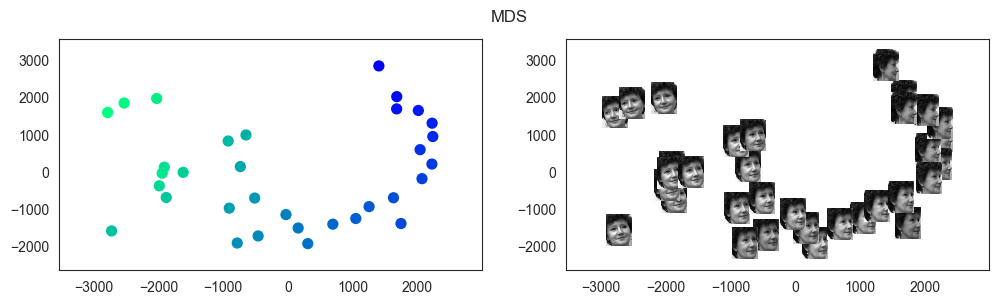

In [11]:
# Plot the 2D positions sorted by the MDS components
plot_2d_sorted_position(mds[:, 0], mds[:, 1], images, GT_ids, "MDS")

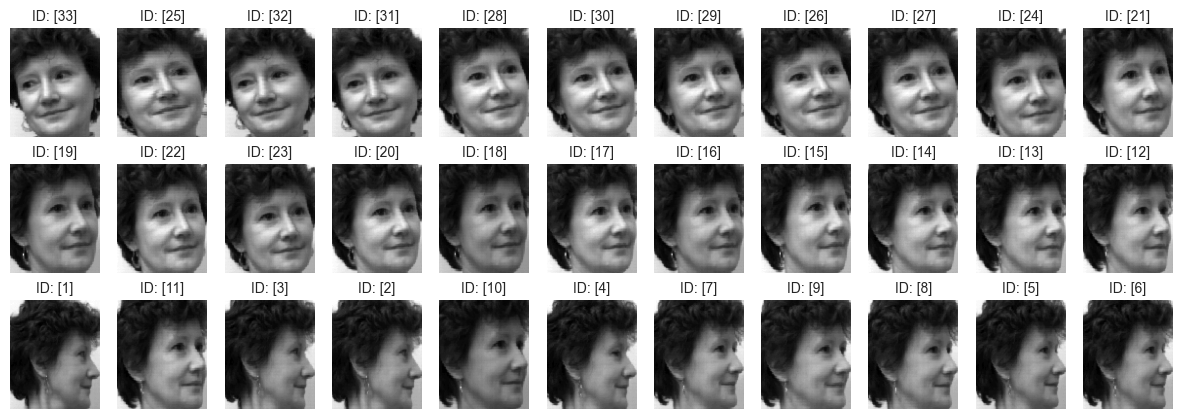

In [12]:
# Extract the first MDS embedding
mds_embedding = mds[:, 0]

# Sort the indices based on the first MDS embedding
sorted_indices = np.argsort(mds_embedding)

# Plot the images sorted by the first MDS embedding
plot_face_with_id(images, GT_ids, indices=sorted_indices)

# 3. ISOMAP embedding
Explore the ISOMAP-embedding of the 33 faces on the k = 5 nearest neighbor graph and compare it against the MDS results.

In [13]:
# Create an Isomap object with n_neighbors=5 and n_components=2
isomap = Isomap(n_neighbors=5, n_components=2).fit_transform(X)

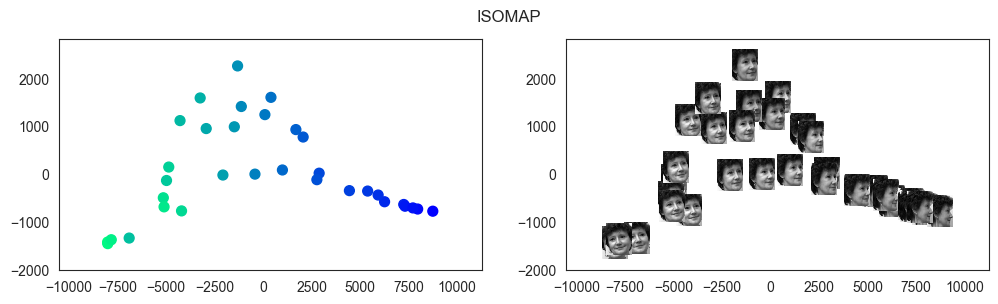

In [14]:
# Plot the 2D positions sorted by the ISOMAP components
plot_2d_sorted_position(isomap[:, 0], isomap[:, 1], images, GT_ids, "ISOMAP")

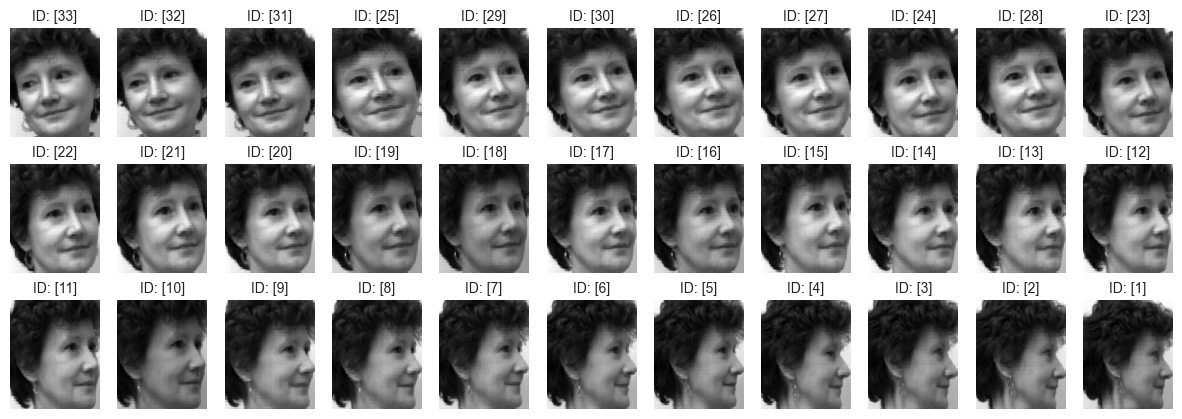

In [15]:
# Get the embedded data from the first ISOMAP component
isomap_embedding = isomap[:, 0]

# Sort the indices based on the embedded data
sorted_indices = np.argsort(isomap_embedding)

# Plot the images sorted by the embedded data
plot_face_with_id(images, GT_ids, indices=sorted_indices)

# 4. LLE/MLLE emdedding
Explore the LLE/MLLE-embedding of the 33 faces on the k = 5 nearest neighbor graph and compare it against ISOMAP.

## 4.1 LLE embedding

In [16]:
# Perform Locally Linear Embedding (LLE) with n_neighbors=5 and n_components=2 using the standard method
lle = LocallyLinearEmbedding(n_neighbors=5, n_components=2, method="standard").fit_transform(X)

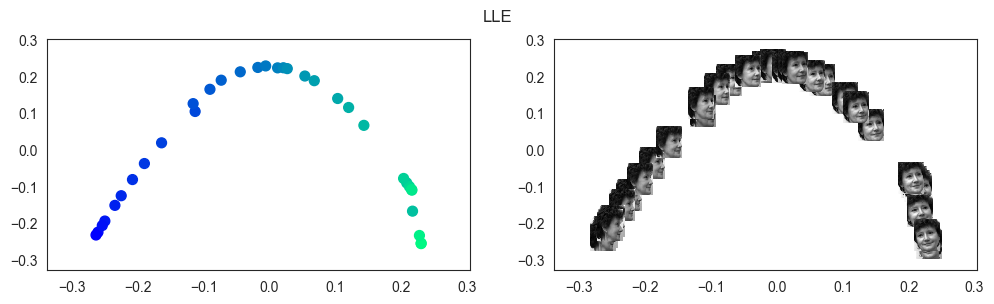

In [17]:
# Plot the 2D positions sorted by the LLE components
plot_2d_sorted_position(lle[:, 0], lle[:, 1], images, GT_ids, "LLE")

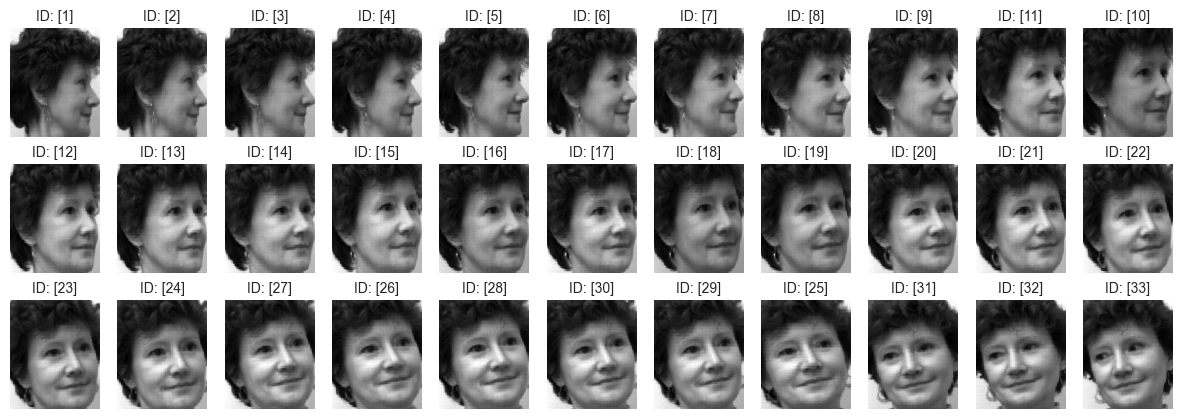

In [18]:
# Get the embedded data from the first LLE component
lle_embedding = lle[:, 0]

# Sort the indices based on the embedded data
sorted_indices = np.argsort(lle_embedding)

# Plot the images sorted by the embedded data
plot_face_with_id(images, GT_ids, indices=sorted_indices)

## 4.2 MLLE embedding

In [19]:
# Perform Locally Linear Embedding (LLE) with n_neighbors=5 and n_components=2 using the modified method
mlle = LocallyLinearEmbedding(n_neighbors=5, n_components=2, method="modified").fit_transform(X)

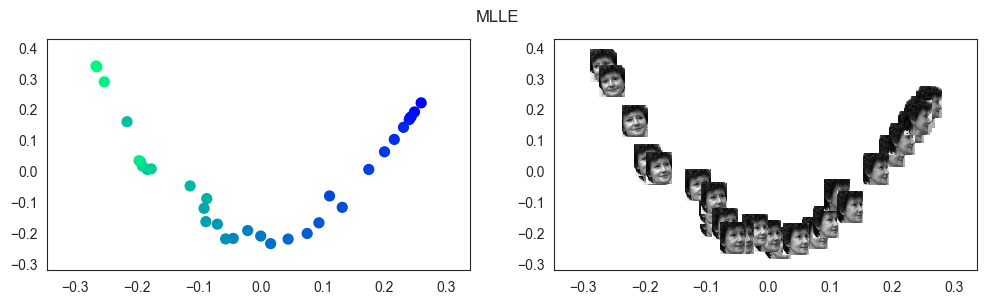

In [20]:
# Plot the 2D positions sorted by the MLLE components
plot_2d_sorted_position(mlle[:, 0], mlle[:, 1], images, GT_ids, "MLLE")

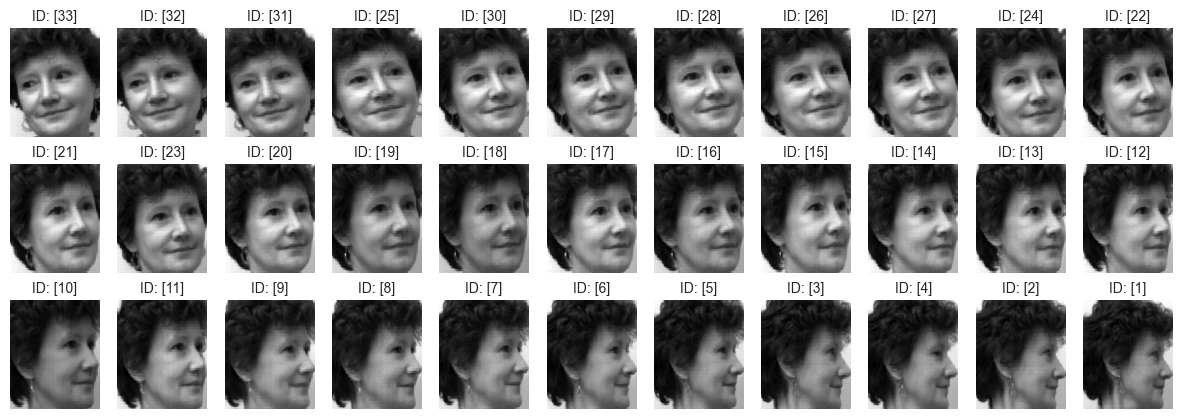

In [21]:
# Get the embedded data from the first MLLE component
mlle_embedding = mlle[:, 0]

# Sort the indices based on the embedded data
sorted_indices = np.argsort(mlle_embedding)

# Plot the images sorted by the embedded data
plot_face_with_id(images, GT_ids, indices=sorted_indices)

# 5.LTSA embedding


Explore the LTSA-embedding of the 33 faces on the k = 5 nearest neighbor graph and compare it against ISOMAP.

In [22]:
# Perform Locally Linear Embedding (LLE) with n_neighbors=5 and n_components=2 using the LTSA method
ltsa = LocallyLinearEmbedding(n_neighbors=5, n_components=2, method="ltsa").fit_transform(X)

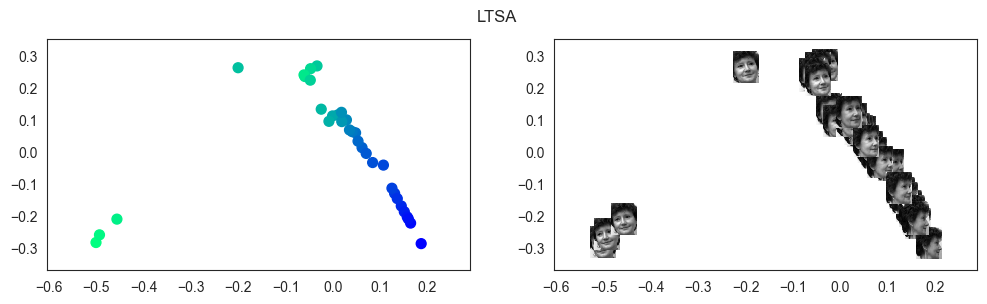

In [23]:
# Plot the 2D positions sorted by the LTSA components
plot_2d_sorted_position(ltsa[:, 0], ltsa[:, 1], images, GT_ids, "LTSA")

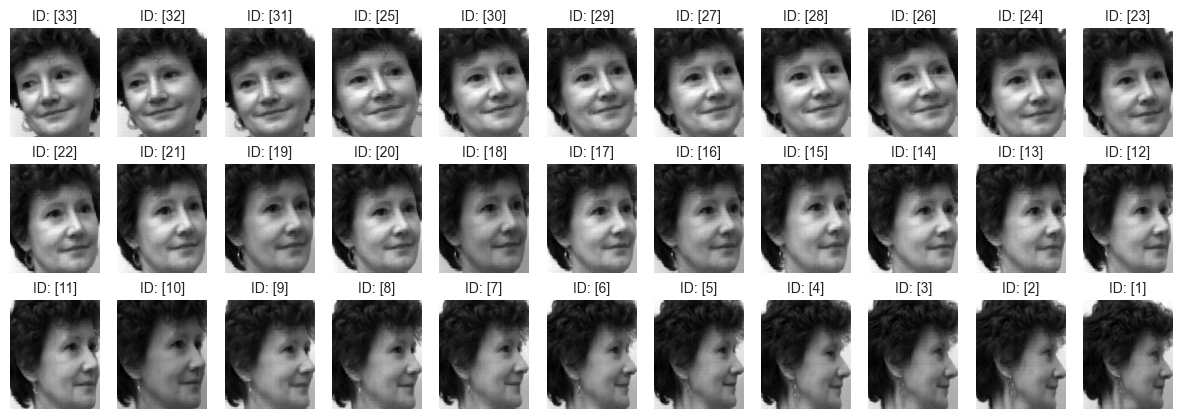

In [24]:
# Get the embedded data from the first LTSA component
ltsa_embedding = ltsa[:, 0]

# Sort the indices based on the embedded data
sorted_indices = np.argsort(ltsa_embedding)

# Plot the images sorted by the embedded data
plot_face_with_id(images, GT_ids, indices=sorted_indices)

# 6. t-SNE embedding
Explore the 2-D t-SNE embedding of the 33 face

## 6.1 Hyperparameters Tuning
The reason for performing hyperparameter tuning for t-SNE is to optimize the algorithm's performance and achieve better visualizations. Adjusting hyperparameters like perplexity, learning rate, and number of iterations helps in finding the right balance between preserving local and global structure in the data. This tuning process aims to prevent overfitting or underfitting, leading to more accurate and meaningful embeddings.

In [25]:
def tsne_optimize(params):
    """
    Optimize t-SNE hyperparameters using Hyperopt.

    Args:
    - params (dict): Dictionary of hyperparameters to optimize.

    Returns:
    - dict: Dictionary containing the loss value (negative Kendall's tau) and optimization status.
    """
    # Unpack parameters
    perplexity = int(params['perplexity'])
    early_exaggeration = params['early_exaggeration']
    learning_rate = params['learning_rate']
    n_iter = int(params['n_iter'])
    random_state = int(params['random_state'])

    # Fit t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration,
                learning_rate=learning_rate, n_iter=n_iter, random_state=random_state)
    transformed = tsne.fit_transform(X)
    tsne_embedding = transformed[:, 0]
    sorted_indices = np.argsort(tsne_embedding)
    tau, _ = kendalltau(GT_ids[0, sorted_indices], np.arange(1, len(GT_ids[0]) + 1))

    # We want to minimize -tau because Hyperopt minimizes the objective
    return {'loss': -abs(tau), 'status': STATUS_OK}

# Define the space of hyperparameters to search
space = {
    'perplexity': hp.quniform('perplexity', 5, 32, 1),
    'early_exaggeration': hp.uniform('early_exaggeration', 1, 20),
    'learning_rate': hp.uniform('learning_rate', 10, 1000),
    'n_iter': hp.quniform('n_iter', 250, 1000, 50),
    'random_state': hp.quniform('random_state', 0, 100, 1)
}

# Run the optimization
trials = Trials()
best_tsne = fmin(
    fn=tsne_optimize,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials,
    rstate=np.random.default_rng(seed=42)
)

print("Best parameters: ", best_tsne)

100%|██████████| 1000/1000 [06:35<00:00,  2.53trial/s, best loss: -0.9734848484848484]
Best parameters:  {'early_exaggeration': 1.201439702358722, 'learning_rate': 97.1458217859962, 'n_iter': 250.0, 'perplexity': 20.0, 'random_state': 63.0}


## 6.2 t-SNE Embedding Result Visualization

In [26]:
# Fit t-SNE with the best hyperparameters found
tsne = TSNE(n_components=2, perplexity=int(best_tsne['perplexity']), early_exaggeration=best_tsne['early_exaggeration'],
            learning_rate=best_tsne['learning_rate'], n_iter=int(best_tsne['n_iter']),
            random_state=int(best_tsne['random_state'])).fit_transform(X)

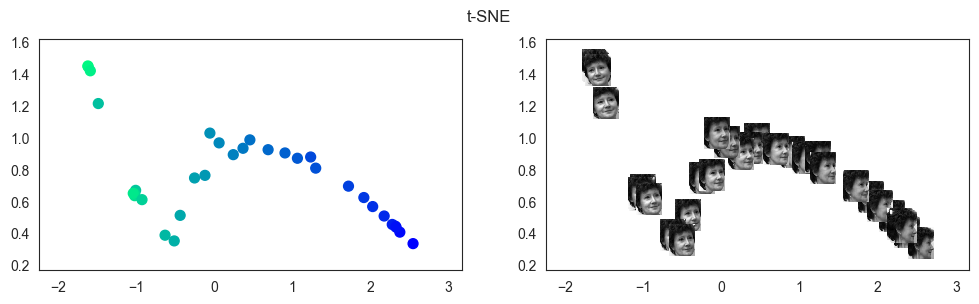

In [27]:
# Plot the 2D positions sorted by the t-SNE components
plot_2d_sorted_position(tsne[:, 0], tsne[:, 1], images, GT_ids, "t-SNE")

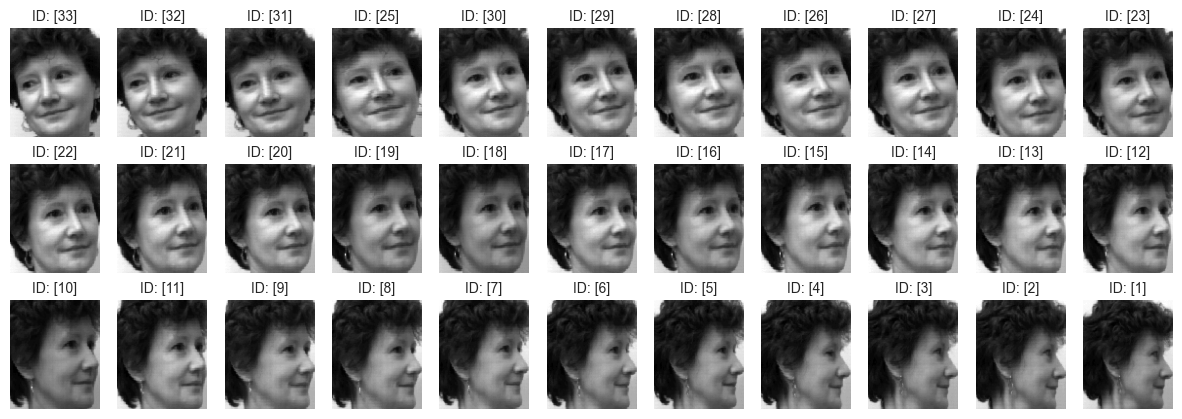

In [28]:
# Get the embedded data from the first t-SNE component
tsne_embedding = tsne[:, 0]

# Sort the indices based on the embedded data
sorted_indices = np.argsort(tsne_embedding)

# Plot the images sorted by the embedded data
plot_face_with_id(images, GT_ids, indices=sorted_indices)

# 7. Additional Dimensionality Reduction Methods

## 7.1 PCA embedding

In [29]:
# Perform Principal Component Analysis (PCA) to reduce the dimensionality to 2
pca = PCA(n_components=2).fit_transform(X)

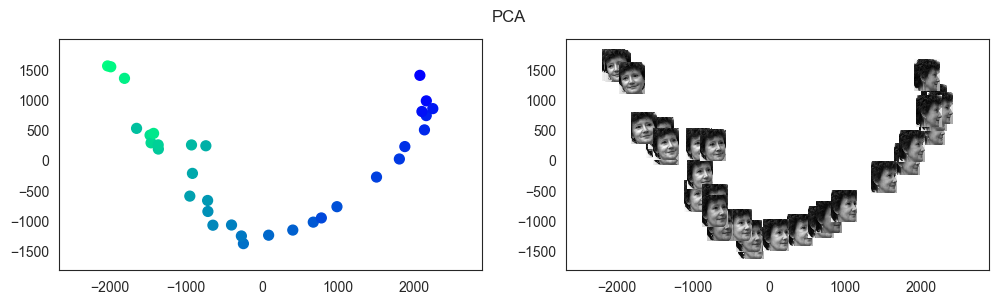

In [30]:
# Plot the 2D positions sorted by the PCA components
plot_2d_sorted_position(pca[:, 0], pca[:, 1], images, GT_ids, "PCA")

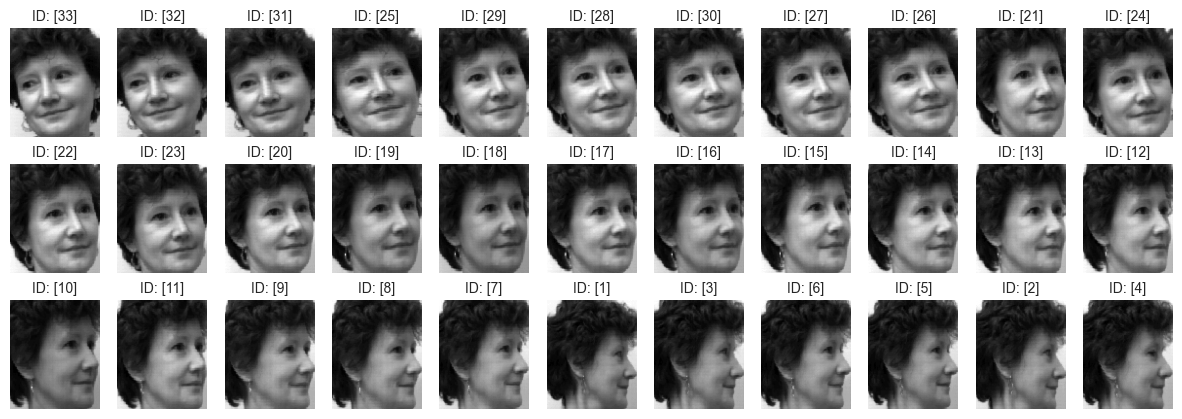

In [31]:
# Get the embedded data from the first PCA component
pca_embedding = pca[:, 0]

# Sort the indices based on the embedded data
sorted_indices = np.argsort(pca_embedding)

# Plot the images sorted by the embedded data
plot_face_with_id(images, GT_ids, indices=sorted_indices)

## 7.2 UMAP embedding

### 7.2.1 Hyperparameters Tuning

In [32]:
# Assume X is your data and GT_ids are the target labels
def umap_optimize(params):
    """
    Optimize UMAP hyperparameters using Hyperopt.

    Args:
    - params (dict): Dictionary of hyperparameters to optimize.

    Returns:
    - dict: Dictionary containing the loss value (negative Kendall's tau) and optimization status.
    """
    # Unpack parameters
    metric = params['metric']
    min_dist = params['min_dist']
    learning_rate = params['learning_rate']
    n_epochs = int(params['n_epochs'])
    spread = params['spread']
    init = params['init']
    random_state = int(params['random_state'])
    # Initialize and fit UMAP
    reducer = UMAP(
        n_components=2,
        n_neighbors=5,
        metric=metric,
        min_dist=min_dist,
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        spread=spread,
        init=init,
        random_state=random_state
    )
    embedding = reducer.fit_transform(X)

    # Calculate embedding quality using Kendall Tau
    sorted_indices = np.argsort(embedding[:, 0])
    tau, _ = kendalltau(GT_ids[0, sorted_indices], np.arange(1, len(GT_ids[0]) + 1))

    # Return the negative tau value because we want to maximize tau
    return {'loss': -abs(tau), 'status': STATUS_OK}

# Define the hyperparameter search space
space = {
    'metric': hp.choice('metric', ['euclidean', 'manhattan', 'cosine']),
    'min_dist': hp.uniform('min_dist', 0.01, 0.5),
    'learning_rate': hp.uniform('learning_rate', 0.1, 2.0),
    'n_epochs': hp.quniform('n_epochs', 200, 2000, 100),
    'spread': hp.uniform('spread', 0.5, 2.0),
    'init': hp.choice('init', ['spectral', 'random']),
    'random_state': hp.quniform('random_state', 0, 100, 1)
}

# Run the optimization
trials = Trials()
best_umap = fmin(
    fn=umap_optimize,
    space=space,
    algo=tpe.suggest,
    max_evals=300,
    trials=trials,
    rstate=np.random.default_rng(seed=40)
)

print("Best parameters: ", best_umap)

100%|██████████| 300/300 [04:43<00:00,  1.06trial/s, best loss: -0.9734848484848484]
Best parameters:  {'init': 0, 'learning_rate': 0.3390340999256821, 'metric': 0, 'min_dist': 0.11941181340294027, 'n_epochs': 1900.0, 'random_state': 38.0, 'spread': 0.7155008213660682}


### 7.2.2 UMAP Embedding Result Visualization

In [33]:
# Define lists for metric and init options
metric_list = ['euclidean', 'manhattan', 'cosine']
init_list = ['spectral', 'random']

# Create UMAP object with best hyperparameters
umap = UMAP(n_components=2, n_neighbors=5, metric=metric_list[best_umap['metric']],
            min_dist=best_umap['min_dist'], learning_rate=best_umap['learning_rate'],
            n_epochs=int(best_umap['n_epochs']), spread=best_umap['spread'],
            init=init_list[best_umap['init']], random_state=int(best_umap['random_state'])).fit_transform(X)

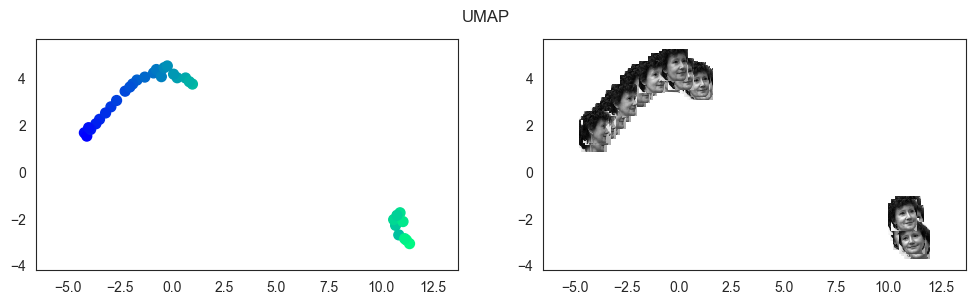

In [34]:
# Plot the 2D positions sorted by the UMAP components
plot_2d_sorted_position(umap[:, 0], umap[:, 1], images, GT_ids, "UMAP")

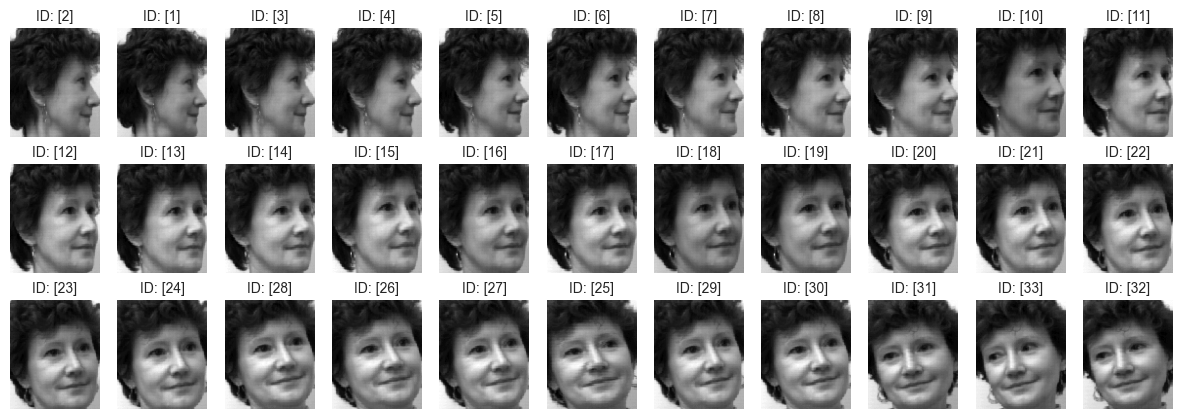

In [35]:
# Get the embedded data from the first UMAP component
umap_embedding = umap[:, 0]

# Sort the indices based on the embedded data
sorted_indices = np.argsort(umap_embedding)

# Plot the images sorted by the embedded data
plot_face_with_id(images, GT_ids, indices=sorted_indices)

# 7. Evaluation

## 7.1 Kendall Tau Correlation Coefficient

In [36]:
# Dictionary of embeddings
embeddings = {
    "Diffusion": diffusion_embedding,
    "MDS": mds_embedding,
    "ISOMAP": isomap_embedding,
    "LLE": lle_embedding,
    "MLLE": mlle_embedding,
    "LTSA": ltsa_embedding,
    "TSNE": tsne_embedding,
    "PCA": pca_embedding,
    "UMAP": umap_embedding
}

# Iterate over the dictionary to calculate and print the Kendall Tau correlation coefficient for each embedding
for name, embedding in embeddings.items():
    sorted_indices = np.argsort(embedding)
    tau, _ = kendalltau(GT_ids[0, sorted_indices], range(1, 34))
    print(f"{name}: {tau}")

Diffusion: -0.6742424242424242
MDS: -0.8181818181818182
ISOMAP: -0.9621212121212122
LLE: 0.9696969696969698
MLLE: -0.9621212121212122
LTSA: -0.9734848484848484
TSNE: -0.9734848484848484
PCA: -0.9204545454545455
UMAP: 0.9734848484848484


## 7.2 Visualization

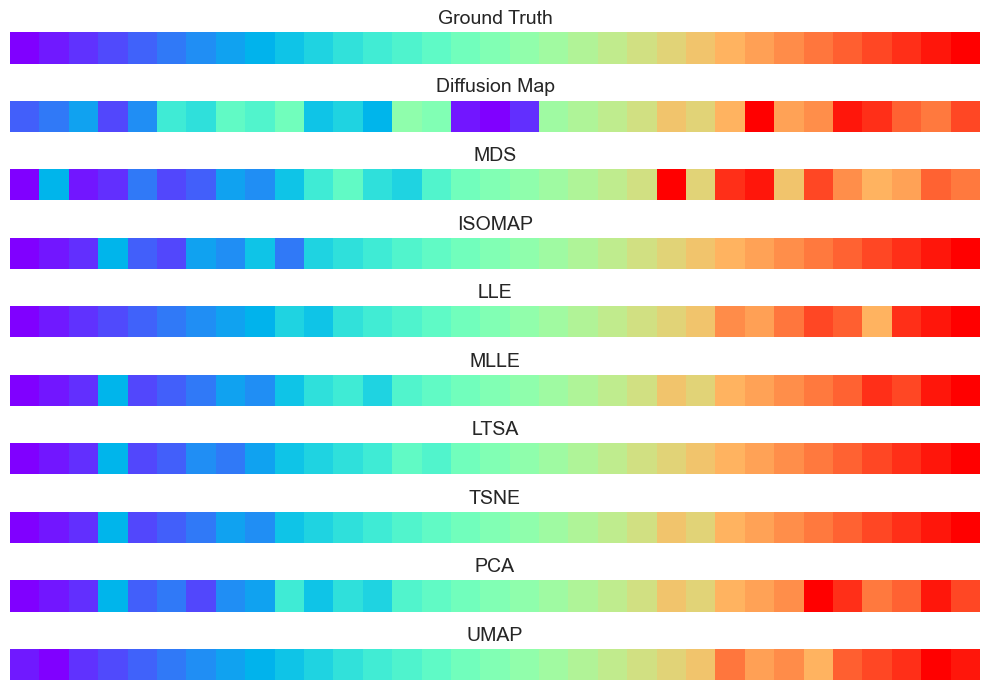

In [37]:
# List of embeddings to visualize
embeddings = [
    ("Ground Truth", None, False),
    ("Diffusion Map", diffusion_embedding, True),
    ("MDS", mds_embedding, True),
    ("ISOMAP", isomap_embedding, True),
    ("LLE", lle_embedding, False),
    ("MLLE", mlle_embedding, True),
    ("LTSA", ltsa_embedding, True),
    ("TSNE", tsne_embedding, True),
    ("PCA", pca_embedding, True),
    ("UMAP", umap_embedding, False)
]

# Create a figure and multiple subplots
plt.figure(figsize=(10, 7))

# Iterate over each embedding
for i, (name, embedding, invert) in enumerate(embeddings, 1):
    ax = plt.subplot(10, 1, i)
    if embedding is None:
        sorted_id = GT_ids[:, GT_indices]
    else:
        sorted_indices = np.argsort(embedding)
        sorted_id = GT_ids[:, sorted_indices]

    # If tau is negative, invert the values
    if invert:
        sorted_id = -sorted_id

    # Plot the heatmap
    sns.heatmap(sorted_id / np.max(sorted_id), cmap="rainbow", cbar=False, ax=ax)
    ax.set_title(name, fontsize=14)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()